# Setting up the Simple `TUM`

In [2]:
from phi.tf.flow import *  # Causes deprecation warnings with TF 1.15
import pylab
import numpy as np
session = Session(None)  # Used to run the TensorFlow graph

%load_ext autoreload
%autoreload 2

/home/intergalactic-mammoth/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/intergalactic-mammoth/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/intergalactic-mammoth/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/interga

In [3]:
#setup

save_imgs = True
res = 8
buoyancy = 0.0
rate = 5
radius = 2

In [4]:
#Create the optimizable simulation
#buoyancy is set to zero

world = World()
fluid = world.add(Fluid(Domain([2*res, 3*res], boundaries=CLOSED), buoyancy_factor=buoyancy), physics=IncompressibleFlow())
world.add(Inflow(Sphere(center=[0.3*res,1.5*res], radius=radius), rate=rate))
world.add(Inflow(Sphere(center=[0.3*res,0.75*res], radius=radius), rate=rate))
world.add(Inflow(Sphere(center=[0.3*res,2.25*res], radius=radius), rate=rate))
#world.add(Inflow(box[0.1*res:0.35*res, 0.5*res:2.5*res], rate = rate))

fluid.velocity = variable(fluid.velocity)  # create TensorFlow variable
states = []
states.append(fluid.state)  # Remember the state at t=0 for later visualization
session.initialize_variables()



In [5]:
#See tensorflow variables
[print(grid.data) for grid in fluid.velocity.unstack()];

<tf.Variable 'Variable/data/0/data:0' shape=(1, 17, 24, 1) dtype=float32_ref>
<tf.Variable 'Variable/data/1/data:0' shape=(1, 16, 25, 1) dtype=float32_ref>


Building graph for frame 0
Building graph for frame 1
Building graph for frame 2
Building graph for frame 3
Building graph for frame 4
Building graph for frame 5
Building graph for frame 6
Building graph for frame 7
Building graph for frame 8
Building graph for frame 9
Building graph for frame 10
Building graph for frame 11
Building graph for frame 12
Building graph for frame 13
Building graph for frame 14
Building graph for frame 15
Building graph for frame 16
Building graph for frame 17
Building graph for frame 18
Building graph for frame 19
Building graph for frame 20
Building graph for frame 21
Building graph for frame 22
Building graph for frame 23
Building graph for frame 24
Building graph for frame 25
Building graph for frame 26
Building graph for frame 27
Building graph for frame 28
Building graph for frame 29
Building graph for frame 30
Building graph for frame 31
Building graph for frame 32
Building graph for frame 33
Building graph for frame 34
Building graph for frame 35
Bu

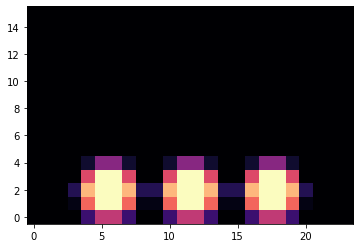

In [6]:
#Build graphs for the simulation
for frame in range(50):
  print('Building graph for frame %d' % frame)
  world.step(dt=0.5)
  states.append(fluid.state)


print('Computing frames...')
pylab.imshow(np.concatenate(session.run(fluid.density).data[...,0], axis=1), origin='lower', cmap='magma')

In [7]:
#Define the target (a png image converted to numpy)
import imageio

target = imageio.imread('tum_08.png')
target = target[:,:,0]
target = np.flip(target)
target = target[:,::-1]
target = np.expand_dims(target, axis=0)
target = np.expand_dims(target, axis=3)

val1 = np.max(fluid.density.data[0:,...])
val2 = np.max(target)
target = val1/val2 * target #normalize the target values to have similar magnitude to the simulation densities

#Define loss, optimizer and start the session
loss = math.l2_loss(fluid.density.data[0:,...] - target)
optim = tf.train.AdamOptimizer(learning_rate=0.25).minimize(loss)
session.initialize_variables()
print('Initial loss: %f' % session.run(loss))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Initial loss: 144044.265625


In [8]:
#Run optimization

for optim_step in range(100):
  print('Running optimization step %d. %s' % (optim_step, '' if optim_step else 'The first step sets up the adjoint graph.'))
  _, loss_value = session.run([optim, loss])
  print('Loss: %f' % loss_value)

Running optimization step 0. The first step sets up the adjoint graph.
Loss: 144044.265625
Running optimization step 1. 
Loss: 66011.921875
Running optimization step 2. 
Loss: 51096.609375
Running optimization step 3. 
Loss: 45118.156250
Running optimization step 4. 
Loss: 40770.835938
Running optimization step 5. 
Loss: 36636.226562
Running optimization step 6. 
Loss: 32969.257812
Running optimization step 7. 
Loss: 30141.792969
Running optimization step 8. 
Loss: 28204.970703
Running optimization step 9. 
Loss: 26868.474609
Running optimization step 10. 
Loss: 25840.105469
Running optimization step 11. 
Loss: 24976.445312
Running optimization step 12. 
Loss: 24238.058594
Running optimization step 13. 
Loss: 23606.488281
Running optimization step 14. 
Loss: 23049.300781
Running optimization step 15. 
Loss: 22531.628906
Running optimization step 16. 
Loss: 22029.394531
Running optimization step 17. 
Loss: 21544.777344
Running optimization step 18. 
Loss: 21086.677734
Running optimizati

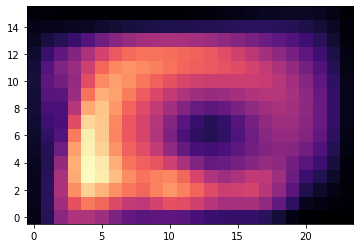

In [9]:
#See what this thing did

pylab.imshow(np.concatenate(session.run(fluid.density).data[...,0], axis=1), origin='lower', cmap='magma')

In [9]:
#Checkout the optimized velocity field

optimized_velocity_field = session.run(states[0].velocity).at_centers()

In [ ]:
pylab.title('Initial y-velocity (optimized)')
pylab.imshow(np.concatenate(optimized_velocity_field.data[...,0], axis=1), origin='lower')

In [ ]:
pylab.title('Initial x-velocity (optimized)')
pylab.imshow(np.concatenate(optimized_velocity_field.data[...,1], axis=1), origin='lower')

Saved image frame 0
Saved image frame 1
Saved image frame 2
Saved image frame 3


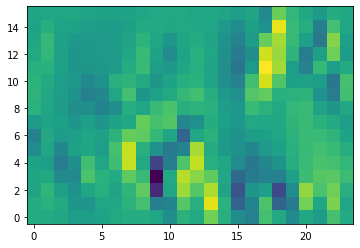

In [13]:
#Saving the optimized density fields as images

if (save_imgs):
    for i in range(4):
        save_name = "vis/density%02d_frame%03d.png"
        pylab.imshow(np.concatenate(session.run(states[i].density).data[...,0], axis=1), origin='lower', cmap='magma')
        pylab.savefig(save_name % (res, i), bbox_inches='tight')

        save_name = "vis/velocity_y_%02d_frame%03d.png"
        pylab.imshow(np.concatenate(session.run(states[i].velocity).at_centers().data[...,0], axis=1), origin='lower')
        pylab.savefig(save_name % (res, i), bbox_inches='tight')

        save_name = "vis/velocity_x_%02d_frame%03d.png"
        pylab.imshow(np.concatenate(session.run(states[i].velocity).at_centers().data[...,1], axis=1), origin='lower')
        pylab.savefig(save_name % (res, i), bbox_inches='tight')

        grad = session.run(states[i+1].velocity).at_centers() - session.run(states[i].velocity).at_centers()
        pylab.imshow(np.concatenate(grad.data[...,1], axis=1), origin='lower')
        save_name = "vis/grad_x_%02d_frame%03d.png"
        pylab.savefig(save_name % (res, i), bbox_inches='tight')
        pylab.imshow(np.concatenate(grad.data[...,0], axis=1), origin='lower')
        save_name = "vis/grad_y_%02d_frame%03d.png"
        pylab.savefig(save_name % (res, i), bbox_inches='tight')

        print("Saved image frame %d" % i)
        

In [ ]:
###For Google collab

#!zip -r /content/file.zip /content/
#from google.colab import files
#files.download("/content/file.zip")